<a href="https://colab.research.google.com/github/Maharaja2627/TIME-SERIES-ANALYSIS/blob/main/EXPT9/EXPT9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install pandas numpy matplotlib scikit-learn tensorflow


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error


In [5]:
# Load dataset
df = pd.read_csv("/content/sample_data/Car_sales.csv")
df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce')
df = df.dropna(subset=['Latest_Launch', 'Sales_in_thousands'])

# Group and sort time series
ts = df.groupby('Latest_Launch')['Sales_in_thousands'].sum().sort_index()

# Normalize the data
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))


In [6]:
def create_dataset(data, look_back=5):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 5
X, y = create_dataset(scaled_ts, look_back)


In [7]:
# 80% train, 20% test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:
model = Sequential()
model.add(Dense(64, input_dim=look_back, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform predictions
train_pred_rescaled = scaler.inverse_transform(train_pred)
test_pred_rescaled = scaler.inverse_transform(test_pred)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_rescaled, train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_pred_rescaled))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Train RMSE: 42.00
Test RMSE: 32.06


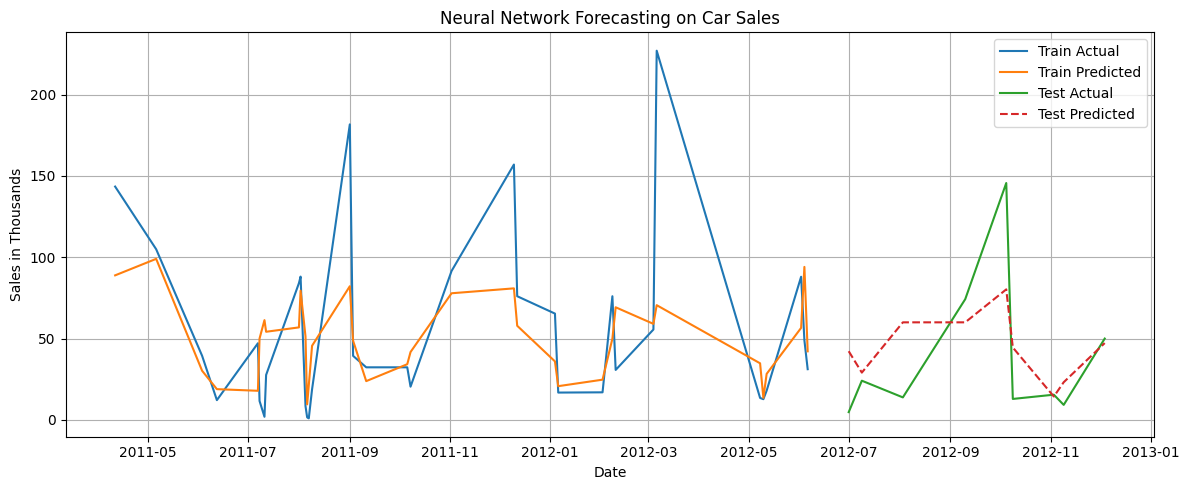

In [10]:
# Combine predictions with original time series for visualization
plt.figure(figsize=(12, 5))
plt.plot(ts.index[look_back:train_size+look_back], y_train_rescaled, label='Train Actual')
plt.plot(ts.index[look_back:train_size+look_back], train_pred_rescaled, label='Train Predicted')
plt.plot(ts.index[train_size+look_back:], y_test_rescaled, label='Test Actual')
plt.plot(ts.index[train_size+look_back:], test_pred_rescaled, label='Test Predicted', linestyle='--')
plt.title('Neural Network Forecasting on Car Sales')
plt.xlabel('Date')
plt.ylabel('Sales in Thousands')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
